In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
import numpy as np
import cv2
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline
from tensorflow.keras.applications.inception_v3 import InceptionV3
import os
import imghdr
import shutil
import random
# import the libraries as shown below
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
# from keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.models import Sequential
from glob import glob
import matplotlib.pyplot as plt
# from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
import pickle
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.regularizers import l1_l2



2023-08-02 11:35:39.785993: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [6]:
import os
from PIL import Image
import shutil


def resize_images(folder_path, target_size, save_folder):
    # Create the save folder if it doesn't exist
    if not os.path.exists(save_folder):
        os.makedirs(save_folder)

    # Iterate over subfolders and files in the given folder
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            # Check if the file is an image
            if file.endswith(('.jpg', '.jpeg', '.png', '.bmp')):
                file_path = os.path.join(root, file)
                # Open the image
                image = Image.open(file_path)
                # Resize the image
                resized_image = image.resize(target_size)
                # Get the relative path of the image (without the main folder path)
                relative_path = os.path.relpath(file_path, folder_path)
                # Construct the save path by joining the save folder and relative path
                save_path = os.path.join(save_folder, relative_path)
                # Create the directories in the save path if they don't exist
                os.makedirs(os.path.dirname(save_path), exist_ok=True)
                # Save the resized image
                resized_image.save(save_path)
                # Close the image
                image.close()


# Usage example
folder_path = './Resized to 299 by 299/'
target_size = (299, 299)
save_folder = './Resized to 299 by 299 c'
resize_images(folder_path, target_size, save_folder)

In [8]:
import os
import cv2


def apply_clahe(image, clip_limit=2.0, tile_grid_size=(8, 8)):
    # Convert the image to LAB color space
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)

    # Split the LAB image into L, A, and B channels
    l, a, b = cv2.split(lab)

    # Apply CLAHE to the L channel
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
    cl = clahe.apply(l)

    # Merge the CLAHE-enhanced L channel with the A and B channels
    lab_clahe = cv2.merge((cl, a, b))

    # Convert the LAB image back to BGR color space
    result_image = cv2.cvtColor(lab_clahe, cv2.COLOR_LAB2BGR)

    return result_image


def preprocess_images(input_folder, output_folder):
    # Create the output folder if it doesn't exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Loop through all subdirectories in the input folder
    for root, _, files in os.walk(input_folder):
        for filename in files:
            if filename.endswith('.jpg'):
                # Load the image
                image_path = os.path.join(root, filename)
                original_image = cv2.imread(image_path)

                # Apply CLAHE to the image
                clahe_image = apply_clahe(original_image)

                # Save the processed image to the output folder with a new name
                output_subfolder = os.path.relpath(root, input_folder)
                output_subfolder_path = os.path.join(
                    output_folder, output_subfolder)
                if not os.path.exists(output_subfolder_path):
                    os.makedirs(output_subfolder_path)

                output_filename = f"processed_{filename}"
                output_image_path = os.path.join(
                    output_subfolder_path, output_filename)
                cv2.imwrite(output_image_path, clahe_image)


# Define the paths for input and output folders
# Replace with the path to your input folder containing images
input_folder = './Resized to 299 by 299/'
# Replace with the path to the folder where processed images will be saved
output_folder = './Processed Images/'

# Preprocess images in the input folder and save them in the output folder
preprocess_images(input_folder, output_folder)

In [9]:
import os
import cv2
import numpy as np


def gray_world(img):
    # Calculate the average color of the image
    avg_color = np.mean(img, axis=(0, 1))

    # Calculate the scaling factor for each color channel
    scale_factor = np.divide(avg_color, 128)

    # Normalize the image by scaling each pixel in each channel
    result = np.divide(img, scale_factor)

    # Clip the pixel values to the range [0, 255]
    result = np.clip(result, 0, 255)

    # Convert the pixel values to 8-bit integers
    result = result.astype(np.uint8)

    return result


# Set the input and output directories
input_dir = "./Resized to 299 by 299/"
output_dir = "./Gray World"

# Iterate over all subfolders and files in the input directory
for root, dirs, files in os.walk(input_dir):
    # Create the corresponding subfolder in the output directory (if it does not exist)
    output_subfolder = os.path.join(
        output_dir, os.path.relpath(root, input_dir))
    os.makedirs(output_subfolder, exist_ok=True)

    # Iterate over all files in the current folder
    for filename in files:
        # Load the input image
        image_path = os.path.join(root, filename)
        img = cv2.imread(image_path)

        # Apply color correction using the Gray World Algorithm
        result = gray_world(img)

        # Get the file extension of the input image
        _, extension = os.path.splitext(filename)

        # Generate a new unique filename for the processed image
        new_filename = f"processed_image_{len(os.listdir(output_subfolder)) + 1}{extension}"
        output_path = os.path.join(output_subfolder, new_filename)

        # Save the result image with the new filename
        cv2.imwrite(output_path, result)

In [10]:
import os
# Define input directory
input_dir = './Resized to 299 by 299 CLAHE , GRAY WORLD/'

# Define output directories
train_dir = './Train'
val_dir = './Validation'
test_dir = './Test'

# Create output directories if they don't exist
for dir in [train_dir, val_dir, test_dir]:
    if not os.path.exists(dir):
        os.makedirs(dir)

# Define the percentage of images to use for validation and test sets
val_pct = 0.2  # 20% of images will be used for validation set
test_pct = 0.1  # 10% of images will be used for test set

# Loop through each subdirectory and move images to train, validation, or test set
for subdir in os.listdir(input_dir):
    subdir_path = os.path.join(input_dir, subdir)
    if os.path.isdir(subdir_path):
        files = os.listdir(subdir_path)
        random.shuffle(files)  # shuffle files randomly
        num_files = len(files)
        val_size = int(num_files * val_pct)
        test_size = int(num_files * test_pct)
        for i, file in enumerate(files):
            src_path = os.path.join(subdir_path, file)
            if i < val_size:
                dst_dir = os.path.join(val_dir, subdir)
            elif i < val_size + test_size:
                dst_dir = os.path.join(test_dir, subdir)
            else:
                dst_dir = os.path.join(train_dir, subdir)
            if not os.path.exists(dst_dir):
                os.makedirs(dst_dir)
            dst_path = os.path.join(dst_dir, file)
            shutil.copy(src_path, dst_path)

In [11]:

# Set up the directories
train_dir = './Train/'
valid_dir = './Validation/'
test_dir = './Test/'

# Set up the data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)
input_shape = (299, 299, 3)
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=input_shape[:2],
    batch_size=32,
    class_mode='sparse'
)

valid_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=input_shape[:2],
    batch_size=32,
    class_mode='sparse'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=input_shape[:2],
    batch_size=32,
    class_mode='sparse'
)

# Load the InceptionV3 model without the top layer
inception = InceptionV3(
    include_top=False, weights='imagenet', input_shape=input_shape)

# Freeze the layers in the base model except the last two inception blocks
for layer in inception.layers[:-14]:
    layer.trainable = False

# Add a custom top layer to the model
x = inception.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

# Build the final model
model = Model(inputs=inception.input, outputs=predictions)

# Define a learning rate scheduler


def learning_rate_scheduler(epoch):
    if epoch < 10:
        return 0.001
    else:
        return 0.0001


# Compile the model with a custom learning rate and metrics
optimizer = keras.optimizers.Adam()
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Define the checkpoint and early stopping callbacks
checkpoint_path = 'model_checkpoint.h5'
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True,
    mode='min',
    verbose=1
)

early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=4,
    mode='min',
    verbose=1
)

# Define the learning rate scheduler callback
lr_scheduler_callback = LearningRateScheduler(learning_rate_scheduler)

# Define a callback to save the history to a file


class SaveHistoryCallback(keras.callbacks.Callback):
    def __init__(self, filename):
        self.filename = filename

    def on_train_begin(self, logs=None):
        self.history = {}

    def on_epoch_end(self, epoch, logs=None):
        for key, value in logs.items():
            self.history.setdefault(key, []).append(value)
        with open(self.filename, 'wb') as f:
            pickle.dump(self.history, f)


# Calculate the number of steps for validation
validation_steps = len(valid_generator.filenames) // valid_generator.batch_size

# Fit the model with the defined callbacks
history_file = 'model_history.pickle'
history_callback = SaveHistoryCallback(history_file)

history = model.fit(
    train_generator,
    steps_per_epoch=len(
        train_generator.filenames) // train_generator.batch_size,
    epochs=25,
    validation_data=valid_generator,
    validation_steps=len(
        valid_generator.filenames) // valid_generator.batch_size,
    callbacks=[checkpoint_callback, early_stopping_callback,
               lr_scheduler_callback, history_callback]
)
# Save the entire model
model.save('experiment 2 after the algorithms applied.h5')

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)

Found 5693 images belonging to 10 classes.
Found 1618 images belonging to 10 classes.
Found 807 images belonging to 10 classes.


2023-08-02 12:21:01.384828: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-08-02 12:21:01.588565: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-08-02 12:21:01.998574: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-08-02 12:21:02.020631: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce 930M computeCapability: 5.0
coreClock: 0.941GHz coreCount: 3 deviceMemorySize: 1.96GiB deviceMemoryBandwidth: 13.41GiB/s
2023-08-02 12:21:02.021097: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2023-08-02 12:21:02.531487: I tensorflow/stream_executor/platform/default/

Epoch 1/25


2023-08-02 12:21:50.759726: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2023-08-02 12:21:53.733035: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 34329984 exceeds 10% of free system memory.
2023-08-02 12:21:56.858938: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 34329984 exceeds 10% of free system memory.
2023-08-02 12:21:57.041162: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2023-08-02 12:22:09.043198: W tensorflow/stream_executor/gpu/asm_compiler.cc:63] Running ptxas --version returned 256
2023-08-02 12:22:09.168543: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 256, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2023-08-02 12:22:13.708479: W tensorflo

  2/177 [..............................] - ETA: 3:56 - loss: 2.5307 - accuracy: 0.1484   

2023-08-02 12:23:05.039006: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 34329984 exceeds 10% of free system memory.


  3/177 [..............................] - ETA: 4:45 - loss: 2.4909 - accuracy: 0.1545

2023-08-02 12:23:06.902196: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 34329984 exceeds 10% of free system memory.


  8/177 [>.............................] - ETA: 4:58 - loss: 2.3083 - accuracy: 0.2307

2023-08-02 12:23:19.927442: W tensorflow/core/common_runtime/bfc_allocator.cc:248] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.48GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2023-08-02 12:23:23.401995: W tensorflow/core/common_runtime/bfc_allocator.cc:248] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.21GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2023-08-02 12:24:03.474591: W tensorflow/core/common_runtime/bfc_allocator.cc:248] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.83GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2023-08-02 12:24:04.354052: W tensorflow/core/common_runtime/bfc_allocator.cc:248] Alloc

177/177 [==============================] - 536s 3s/step - loss: 1.3499 - accuracy: 0.5600 - val_loss: 0.3884 - val_accuracy: 0.8719

Epoch 00001: val_loss improved from inf to 0.38841, saving model to model_checkpoint.h5
Epoch 2/25
177/177 [==============================] - 303s 2s/step - loss: 0.5035 - accuracy: 0.8396 - val_loss: 0.2638 - val_accuracy: 0.9162

Epoch 00002: val_loss improved from 0.38841 to 0.26377, saving model to model_checkpoint.h5
Epoch 3/25
177/177 [==============================] - 300s 2s/step - loss: 0.3467 - accuracy: 0.8863 - val_loss: 0.2592 - val_accuracy: 0.9219

Epoch 00003: val_loss improved from 0.26377 to 0.25922, saving model to model_checkpoint.h5
Epoch 4/25
177/177 [==============================] - 305s 2s/step - loss: 0.2504 - accuracy: 0.9140 - val_loss: 0.1787 - val_accuracy: 0.9450

Epoch 00004: val_loss improved from 0.25922 to 0.17871, saving model to model_checkpoint.h5
Epoch 5/25
177/177 [==============================] - 306s 2s/step - lo

Found 807 images belonging to 10 classes.


/home/surafelamsalu21/anaconda3/envs/surafel/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '



Classification Report:

                    precision    recall  f1-score   support

    Acer campestre       0.95      0.97      0.96       102
      Acer negundo       0.96      0.93      0.94       109
     Arbutus unedo       0.99      0.97      0.98       153
     Betula utilis       0.98      1.00      0.99        42
Buxus sempervirens       0.99      0.99      0.99       138
       Pinus nigra       0.94      0.91      0.93        35
        Salix alba       0.90      0.96      0.93        49
     Smilax aspera       0.99      1.00      0.99        66
  Viburnum lantana       0.92      0.98      0.95        50
   Viburnum opulus       0.93      0.89      0.91        63

          accuracy                           0.96       807
         macro avg       0.96      0.96      0.96       807
      weighted avg       0.96      0.96      0.96       807



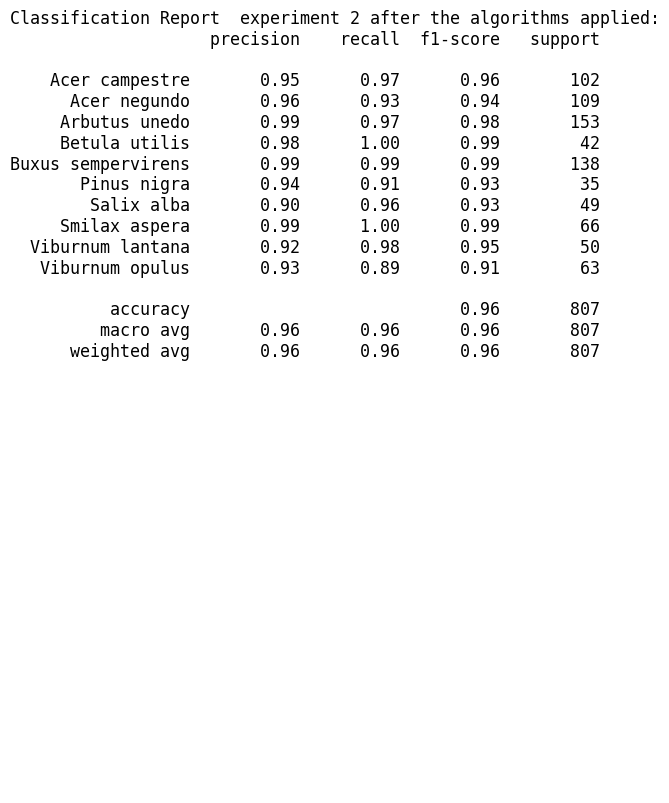

In [12]:
import os
from itertools import product
import sklearn


import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model

# Define the directories for your train, validation, and test data
train_dir = './Train'
valid_dir = './Validation'
test_dir = './Test'

# Define the image size and batch size for testing
img_size = 299
batch_size = 32

# Load the saved model
model = load_model(
    './experiment 2 after the algorithms applied.h5')

# Load and preprocess the test data using an image data generator
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False)

# Get the predicted labels for the test data
y_pred = model.predict_generator(test_generator)

# Get the true labels for the test data
y_true = test_generator.classes

# Get the class names for the test data
class_names = list(test_generator.class_indices.keys())

# Print the classification report for the test data
print('\nClassification Report:\n')
y_pred_class = np.argmax(y_pred, axis=1)
classification_report_str = classification_report(
    y_true, y_pred_class, target_names=class_names)
print(classification_report_str)

# Save the classification report as an image
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
ax.axis('off')
ax.text(0, 0.9, 'Classification Report  experiment 2 after the algorithms applied:\n' +
        classification_report_str, fontsize=12, family='monospace')
plt.savefig('Classification Report experiment 2 after the algorithms applied.png',
            bbox_inches='tight', pad_inches=0)

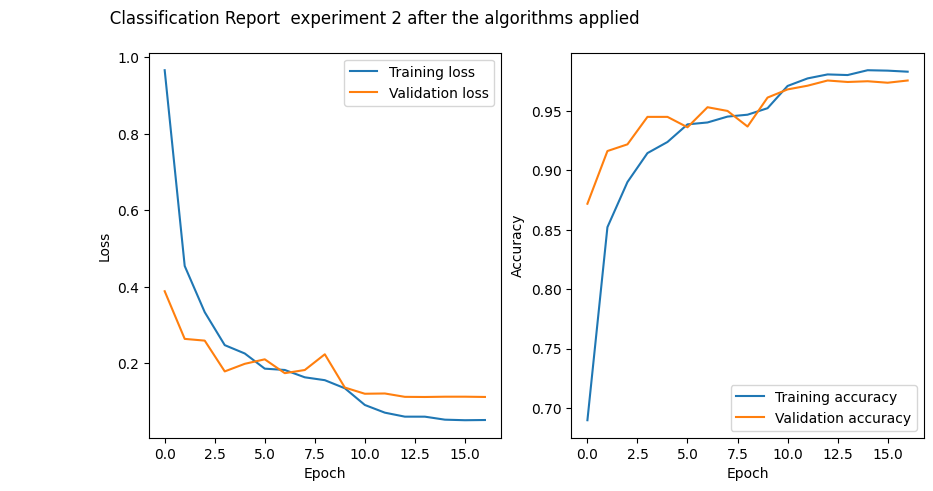

In [13]:
import matplotlib.pyplot as plt
import pickle

# Load the saved history object
with open('./model_history.pickle', 'rb') as f:
    history = pickle.load(f)

# Plot the training and validation loss curves
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history['loss'], label='Training loss')
plt.plot(history['val_loss'], label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('                   Classification Report  experiment 2 after the algorithms applied\n')

# Plot the training and validation accuracy curves
plt.subplot(1, 2, 2)
plt.plot(history['accuracy'], label='Training accuracy')
plt.plot(history['val_accuracy'], label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
# plt.title('Training and Validation Accuracy before ')

plt.show()